In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [2]:
# Load the dataset
data = pd.read_csv(r"Desktop/creditcard.csv")

# Separate features and labels
X = data.drop('Class', axis=1)
y = data['Class']

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Filter normal transactions (Class == 0) for training
X_train_normal = X_train[y_train == 0]
print(f"Number of normal transactions in training set: {X_train_normal.shape[0]}")


Number of normal transactions in training set: 227451


In [4]:
# Define the Autoencoder model
input_dim = X_train_normal.shape[1]
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(32, activation='relu'),   # Encoder layer
    tf.keras.layers.Dense(16, activation='relu'),   # Encoder layer
    tf.keras.layers.Dense(8, activation='relu'),    # Latent representation
    tf.keras.layers.Dense(16, activation='relu'),   # Decoder layer
    tf.keras.layers.Dense(32, activation='relu'),   # Decoder layer
    tf.keras.layers.Dense(input_dim, activation='sigmoid')  # Output layer
])

In [5]:
autoencoder.compile(optimizer='adam', loss='mse')


Epoch 1/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9077 - val_loss: 0.8642
Epoch 2/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8178 - val_loss: 0.8290
Epoch 3/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7951 - val_loss: 0.8117
Epoch 4/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7842 - val_loss: 0.8057
Epoch 5/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.7780 - val_loss: 0.8006
Epoch 6/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7748 - val_loss: 0.7976
Epoch 7/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.7727 - val_loss: 0.7955
Epoch 8/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7703 - val_loss: 0.7928
Epoch 9/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7678 - val_loss: 0.7910
Epoch 10/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7654 - val_loss: 0.7887
Epoch 11/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.7632 - val_loss: 0.7861
Epoch 12/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

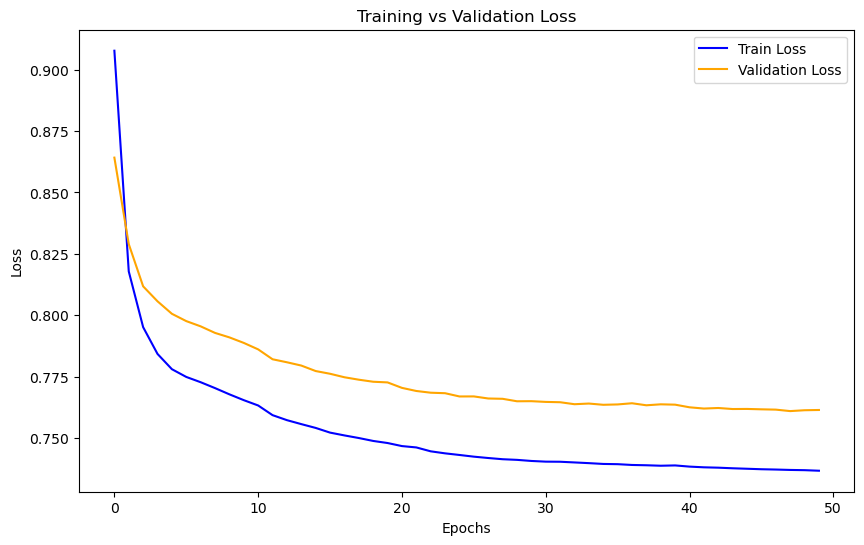

In [6]:
history = autoencoder.fit(X_train_normal, X_train_normal,
                          epochs=50,
                          batch_size=256,
                          validation_data=(X_test, X_test),
                          shuffle=True)

# Visualize training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Threshold for anomaly detection: 1.4625134242482878
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.90      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.92      0.52     56962
weighted avg       1.00      0.95      0.97     56962

Confusion Matrix:
[[54020  2844]
 [   10    88]]


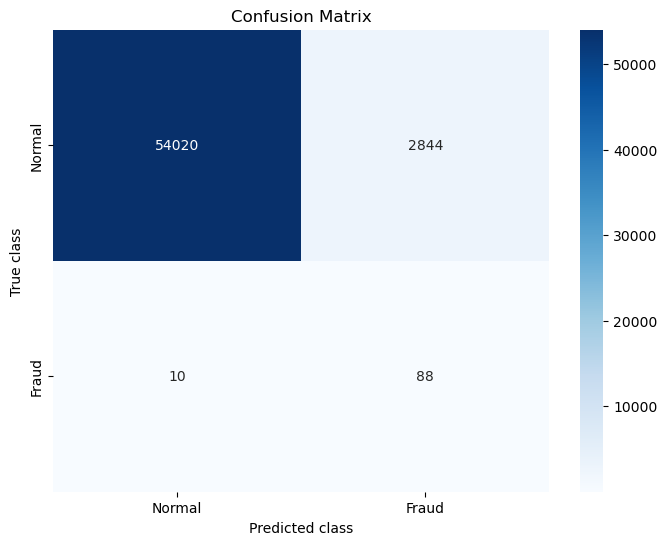

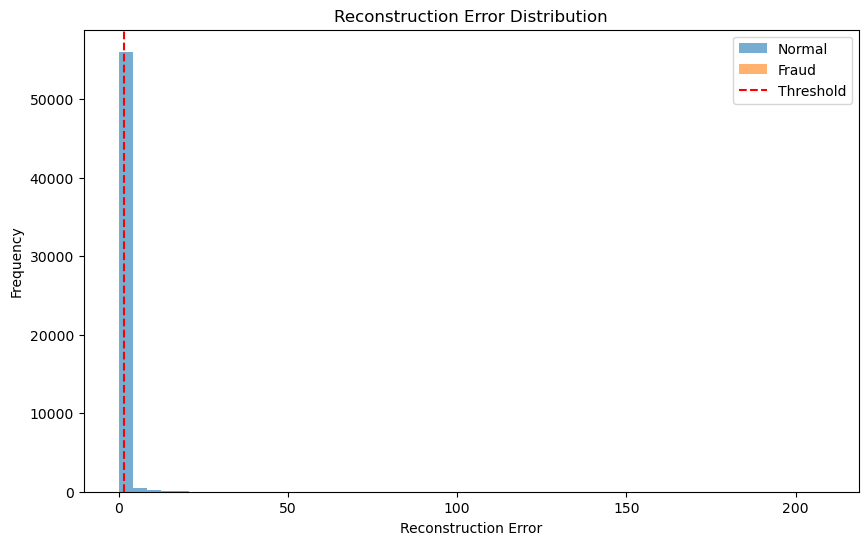

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Sample 0:
  Reconstruction Error: 65.43102109896624
  Prediction: Fraud (Threshold: 1.4625134242482878)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Sample 1:
  Reconstruction Error: 0.8536748713920759
  Prediction: Normal (Threshold: 1.4625134242482878)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Sample 2:
  Reconstruction Error: 0.3139895542181988
  Prediction: Normal (Threshold: 1.4625134242482878)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Sample 3:
  Reconstruction Error: 0.30242495858148577
  Prediction: Normal (Threshold: 1.4625134242482878)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Sample 4:
  Reconstruction Error: 0.20062556752997238
  Prediction: Normal (Threshold: 1.4625134242482878)


In [7]:
# Calculate reconstruction error on the test set
X_test_predictions = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - X_test_predictions), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(mse[y_test == 0], 95)
print(f"Threshold for anomaly detection: {threshold}")

# Classify anomalies
y_pred = (mse > threshold).astype(int)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Visualization of reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(mse[y_test == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(mse[y_test == 1], bins=50, alpha=0.6, label='Fraud')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Show reconstruction error and prediction for a few samples
sample_indices = [0, 1, 2, 3, 4]
for index in sample_indices:
    sample = X_test[index]
    reconstruction = autoencoder.predict(sample.reshape(1, -1))
    error = np.mean(np.square(sample - reconstruction))
    prediction = "Fraud" if error > threshold else "Normal"
    print(f"Sample {index}:")
    print(f"  Reconstruction Error: {error}")
    print(f"  Prediction: {prediction} (Threshold: {threshold})")
